# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [ ]:
import pandas as pd
import bz2

with bz2.open("speeches-201718.json.bz2") as source:
    speeches_201718 = pd.read_json(source)

with bz2.open("speeches-201819.json.bz2") as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [4]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [ ]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [6]:
parties = sorted(training_data["party"].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by plotting a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

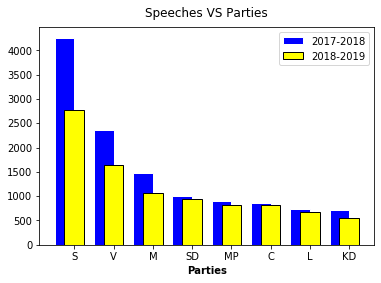

In [8]:
#plot the distribution of the classes
import matplotlib.pyplot as plt
x1 = training_data["party"].unique()
y1 = training_data["party"].value_counts()
x2 = test_data["party"].unique()
y2 = test_data["party"].value_counts()
r1 = np.arange(len(y1))
r2 = [x + 0.25 for x in r1]

plt.bar(r1, y1, color='blue', edgecolor='white',width = 0.5,
 label='2017-2018')
plt.bar(r2, y2, color='yellow', edgecolor='black', width = 0.5,
label='2018-2019')
plt.xlabel('Parties', fontweight='bold')
plt.xticks([r + 0.25 for r in range(len(y1))], x1)

plt.title("Speeches VS Parties", y=1.02)
plt.legend()
plt.show()

### Analysis

We can see from the comparison on [Wikipedia](https://en.wikipedia.org/wiki/2018_Swedish_general_election) the changes between won seats as following:  

**Increases:**  
- SD: (13 seats)  
- C: (9 seats)  
- V: (7 seats)  
- KD: (6 seats)  
- L: (1 seats)

**Decreases:**  
- S: (13 seats)  
- M: (14 seats)  
- MP: (9 seats)

We can see the MP lost 9 seats and in the plot above they also decreased their speeches in 2018 almost half, so it may be the reason the lost seats. Also, it is very clear to see that all parties in the **Increased** category keep their speech count nearly same like in 2017 with so small differences. On the other hand, S, M and MP decreased their speech activity very significantly. We can conclude this as speech counts effected very much to the results of election in 2018.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

### Implementation with Pipeline (sklearn)

In [ ]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# define the steps for our pipeline
steps = [("tfidfVectorizer", CountVectorizer()), ("multiNB", MultinomialNB())]
# define pipeline object
pipeline = Pipeline(steps)

In [ ]:
# To implement a pipeline with sklearn we should 
# split the label from our data
trainX, trainY = training_data.drop(["party"], axis=1), training_data["party"]
testX, testY = test_data.drop(["party"], axis=1), test_data["party"]

In [11]:
# define the parameters of pipeline steps
params = {
    "multiNB__alpha":1.0    
}
# fit the classifier by using the pipeline
pipeline.fit(trainX["words"], trainY)

Pipeline(memory=None,
         steps=[('tfidfVectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('multiNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# prediction
preds = pipeline.predict(testX["words"])

In [13]:
#Evaluation on train data
pipeline.score(trainX["words"], trainY)

0.7600259256258608

In [14]:
#Evaluation on test data
pipeline.score(testX["words"], testY)

0.4280792420327304

In [15]:
from sklearn.metrics import classification_report
print(classification_report(testY, preds, target_names=parties))

              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



### Standard Implementation

In [ ]:
# define and fit vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(training_data["words"])
# data
X_train = vectorizer.transform(training_data["words"])
y_train = training_data["party"]

X_test = vectorizer.transform(test_data["words"])
y_test = test_data["party"] 

In [17]:
nbClassifier = MultinomialNB()
nbClassifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
stdPreds = nbClassifier.predict(X_test)

In [19]:
np.sum(stdPreds == y_test) / len(y_test)

0.4280792420327304

Would you have expected the results that you got?

### Analysis
In this task we implement a Multinomial Bayes classifier with default choice of parameters.

We can now evaluate the classifier using the above results. The accuracy is approximately 43% which is quite low. One can say that we could expected that because of the unbalanced data. Accuracy is just a number though. In order to have a more clear picture, we should compare the accuracies of different models. 

## Problem 3: Baseline

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline for text classification is **Most Frequent Class (MFC)**. One way to think of this baseline is as a classifier that, for every document, predicts that class which appears most often in the training data.

Determine the most frequent class in the 2017/2018 data. What is the accuracy of the MFC baseline on the test data? Given this baseline accuracy, how do you assess the results of the Naive Bayes classifier from Problem&nbsp;2? Answer with a short text.

In [20]:
freqClass = speeches_201718["party"].value_counts().idxmax()
MFC_accuracy = test_data["party"].value_counts()[freqClass]/test_data.shape[0]

print("Most Frequent Class (MFC): " + freqClass, "\nMFC Accuracy: " + str(MFC_accuracy))

Most Frequent Class (MFC): S 
MFC Accuracy: 0.298557278208441


### Analysis

It is obvious that a baseline classifier will give most of the times poor performance. In that case the accuracy of the MFC baseline is approximately 0.3 which is lower by 13% from the Bayes classifier. Therefore, it seems that the structure of the data causes problem in order to predict the classes correct. We can also comment that for the given problem, the accuracy of the Bayes classifier is quite good, even if the 43% seems low.

## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Discuss your findings in a short text. Would you argue that undersampling make sense for the task of predicting the party of a speaker?

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [ ]:
lowestCount = training_data["party"].value_counts()[-1]
labels = training_data["party"].unique()
newTrain = pd.DataFrame()
for l in labels:
    newTrain = newTrain.append(training_data[training_data["party"]==l].sample(lowestCount, replace=False, random_state=12345))

In [22]:
newTrain.shape

(5752, 3)

In [23]:
# Evaluation of balanced newTrain data with test data
pipeline.fit(newTrain["words"], newTrain["party"])
preds = pipeline.predict(testX["words"])
pipeline.score(testX["words"], testY)

0.40654608096468564

In [24]:
print(classification_report(testY, preds, target_names=parties))

              precision    recall  f1-score   support

           C       0.28      0.43      0.34       671
          KD       0.32      0.39      0.35       821
           L       0.28      0.43      0.34       560
           M       0.40      0.51      0.45      1644
          MP       0.35      0.39      0.37       809
           S       0.80      0.28      0.42      2773
          SD       0.43      0.42      0.43      1060
           V       0.39      0.57      0.46       950

    accuracy                           0.41      9288
   macro avg       0.41      0.43      0.39      9288
weighted avg       0.49      0.41      0.41      9288



### Analysis

Undersampling provides us better recall scores, and better balance between precision and recall. We can see this effect from f1-scores. Although we have lower accuracy, we have higher f1-scores which makes our classifier more balanced.

Undersampling is a really simple techinque but it can work efficient enough in many causes. In that case thought, it seems that that method can not help. A reason could be that we train our classifier in less data than before(5752 instead of 12343). Moreover, using the count Vectorization technique, the number of features we have is really high(75125).

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table layout that is useful when analysing the performance of a classifier. In this matrix, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

Your task is to use the confusion matrix to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses $p$ with when it predicts the party of a speaker.

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(testY, preds)

In [26]:
dfConfMatrix = pd.DataFrame(conf_matrix, index=parties, columns=parties)
dfConfMatrix

,C,KD,L,M,MP,S,SD,V
C,288,57,47,105,47,18,55,54
KD,87,324,55,158,33,24,66,74
L,52,47,241,63,32,10,45,70
M,192,163,130,831,84,40,110,94
MP,60,56,57,104,316,72,47,97
S,202,221,184,491,321,789,205,360
SD,90,86,98,188,39,16,449,94
V,53,65,59,113,35,16,71,538


In [27]:
mostConfusingParties = [(k, v[v!=v[k]].idxmax()) for (k,v) in dfConfMatrix.iterrows()]
mostConfusingParties

[('C', 'M'),
 ('KD', 'M'),
 ('L', 'V'),
 ('M', 'C'),
 ('MP', 'M'),
 ('S', 'M'),
 ('SD', 'M'),
 ('V', 'M')]

The diagonal of the confusion matrix gives us the proportion of each class which classified correctly. In that task, we went through each row in order to find the most common class for each missclassified class. 

In the list above, the first element in the tuple is the true label, and the second is the most common label when the class is misclassified. As we cna see in almost all the classes, the "misleading" class is "M".

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. (Why would that be a bad idea?) Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words model instead of the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting $n$-grams up to $n = 2$ (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [ ]:
parameters = {
    "tfidfVectorizer__ngram_range": [(1,1), (1,2)],
    "tfidfVectorizer__binary": [True, False],
    "multiNB__alpha": [1,0.1]
}

In [29]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=1)
grid.fit(training_data["words"], training_data["party"])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfVectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

In [30]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multiNB__alpha,param_tfidfVectorizer__binary,param_tfidfVectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.238394,0.052837,0.550300,0.022317,1,True,"(1, 1)","{'multiNB__alpha': 1, 'tfidfVectorizer__binary...",0.474302,0.468206,0.471851,0.474878,0.455393,0.468930,0.007161,6
1,8.697752,0.160871,1.345931,0.031226,1,True,"(1, 2)","{'multiNB__alpha': 1, 'tfidfVectorizer__binary...",0.397005,0.388821,0.397327,0.410454,0.390511,0.396824,0.007614,8
2,2.203430,0.024813,0.548748,0.022635,1,False,"(1, 1)","{'multiNB__alpha': 1, 'tfidfVectorizer__binary...",0.514771,0.509923,0.521669,0.500000,0.486212,0.506522,0.012359,5
3,8.553581,0.119712,1.341935,0.043862,1,False,"(1, 2)","{'multiNB__alpha': 1, 'tfidfVectorizer__binary...",0.420478,0.404617,0.409072,0.419773,0.403082,0.411407,0.007391,7
4,2.215343,0.019373,0.547394,0.026578,0.1,True,"(1, 1)","{'multiNB__alpha': 0.1, 'tfidfVectorizer__bina...",0.591259,0.622924,0.597408,0.563614,0.547445,0.584542,0.026445,2
5,8.619079,0.167821,1.353370,0.028299,0.1,True,"(1, 2)","{'multiNB__alpha': 0.1, 'tfidfVectorizer__bina...",0.575071,0.575537,0.586067,0.553485,0.545418,0.567123,0.015163,4
6,2.209323,0.026077,0.556095,0.023086,0.1,False,"(1, 1)","{'multiNB__alpha': 0.1, 'tfidfVectorizer__bina...",0.603804,0.625759,0.592548,0.562804,0.545823,0.586162,0.028606,1
7,8.570942,0.180662,1.354736,0.032085,0.1,False,"(1, 2)","{'multiNB__alpha': 0.1, 'tfidfVectorizer__bina...",0.582760,0.602673,0.596193,0.559157,0.567721,0.581706,0.016458,3


In [31]:
preds = grid.best_estimator_.predict(testX["words"])
print(classification_report(testY, preds))

              precision    recall  f1-score   support

           C       0.39      0.27      0.32       671
          KD       0.45      0.24      0.31       821
           L       0.37      0.26      0.30       560
           M       0.44      0.58      0.50      1644
          MP       0.32      0.46      0.38       809
           S       0.61      0.65      0.63      2773
          SD       0.49      0.43      0.45      1060
           V       0.50      0.42      0.46       950

    accuracy                           0.48      9288
   macro avg       0.45      0.41      0.42      9288
weighted avg       0.48      0.48      0.48      9288



In [32]:
grid.best_params_

{'multiNB__alpha': 0.1,
 'tfidfVectorizer__binary': False,
 'tfidfVectorizer__ngram_range': (1, 1)}

## problem 6: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;5? Answer with a short text.

### Preprocess Function

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import string
# define stemmer will be used in preprocessing
stemmer = SnowballStemmer("swedish")
# define punctuation table
table = str.maketrans('', '', string.punctuation)
# define stopwords
stopwords_sw = set(stopwords.words("swedish"))

def preprocess(text):
    words = []
    for t in word_tokenize(text):
        t_ = t.lower().translate(table)
        if(not t_ in stopwords_sw and t_.isalpha()):
            words.append(stemmer.stem(t_))
    return(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Model Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [35]:
countVectorizer = CountVectorizer(tokenizer=preprocess)
pipelines = [
    ("randomForest", 
     Pipeline([("countVectorizer", countVectorizer), 
               ("classifier", RandomForestClassifier(n_estimators=200, 
                                                     max_depth=3, 
                                                     random_state=0))])),
    ("linearSVC", 
     Pipeline([("countVectorizer", countVectorizer), 
               ("classifier", LinearSVC(max_iter=10000))])),
    ("multinomialNB", 
     Pipeline([("countVectorizer", countVectorizer), 
               ("classifier", MultinomialNB())])),
    ("logisticRegression", 
     Pipeline([("countVectorizer", countVectorizer), 
               ("classifier", LogisticRegression(random_state=0, 
                                                 multi_class="multinomial", 
                                                 solver="lbfgs", 
                                                 max_iter=350))]))    
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(pipelines)))
entries = []

for (model_name, pipeline) in pipelines:
    print(model_name)
    accuracies = cross_val_score(pipeline, 
                                 training_data["words"], 
                                 training_data["party"], 
                                 scoring="accuracy", cv=CV, 
                                 verbose=1)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

randomForest


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


linearSVC


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


multinomialNB


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


logisticRegression


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished


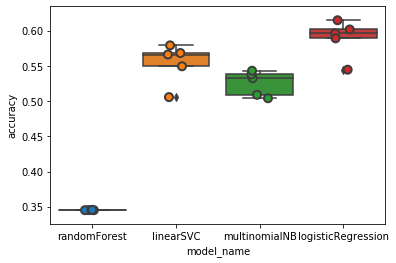

In [36]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### Analysis

First we did preprocessing in the data and we got better results for Naive Bayes classifier which is implemented in previous task. We can see that in the plot, avarage accuracy of cross-validation is better.  
In model selection, we got better results for logistic regression and in the next topic we are going to use this classifier to fit its hyperparameters and we will test the best model with best hyperparameters.

### Best Model (Logistic Regression) Grid Search

In [40]:
pipelineLogistic = pipelines[3][1]

parameters = {
    "countVectorizer__ngram_range": [(1,1), (1,2)],
    "countVectorizer__binary": [True, False],
    "classifier__C": [0.1, 1, 10]
}

from sklearn.model_selection import GridSearchCV
gridBest = GridSearchCV(pipelineLogistic, param_grid=parameters, cv=5, verbose=1)
gridBest.fit(training_data["words"], training_data["party"])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Incr

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('countVectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

In [41]:
pd.DataFrame(gridBest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_countVectorizer__binary,param_countVectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,51.715725,0.264493,6.969098,0.306837,0.1,True,"(1, 1)","{'classifier__C': 0.1, 'countVectorizer__binar...",0.614731,0.642770,0.625354,0.620340,0.576237,0.615896,0.021928,3
1,243.844273,3.828050,7.353055,0.133572,0.1,True,"(1, 2)","{'classifier__C': 0.1, 'countVectorizer__binar...",0.610279,0.633860,0.616849,0.625608,0.585969,0.614518,0.016338,4
2,61.017247,1.795527,6.791278,0.282562,0.1,False,"(1, 1)","{'classifier__C': 0.1, 'countVectorizer__binar...",0.603399,0.631025,0.610774,0.608590,0.557989,0.602366,0.024080,8
3,265.812694,6.037812,7.111387,0.237812,0.1,False,"(1, 2)","{'classifier__C': 0.1, 'countVectorizer__binar...",0.608256,0.634265,0.620089,0.604133,0.569749,0.607308,0.021496,5
4,69.611929,0.930848,6.684204,0.261139,1,True,"(1, 1)","{'classifier__C': 1, 'countVectorizer__binary'...",0.600162,0.628190,0.614419,0.589546,0.555150,0.597505,0.024861,9
5,286.030347,7.997707,7.097815,0.306075,1,True,"(1, 2)","{'classifier__C': 1, 'countVectorizer__binary'...",0.616754,0.635480,0.625759,0.629254,0.576237,0.616706,0.021109,2
6,79.297661,1.908873,6.774924,0.279334,1,False,"(1, 1)","{'classifier__C': 1, 'countVectorizer__binary'...",0.601781,0.614824,0.596193,0.589141,0.544607,0.589322,0.023876,10
7,319.549199,8.316026,7.114149,0.299405,1,False,"(1, 2)","{'classifier__C': 1, 'countVectorizer__binary'...",0.611898,0.637505,0.619684,0.605348,0.557178,0.606336,0.026817,6
8,80.708249,0.587098,6.738414,0.273950,10,True,"(1, 1)","{'classifier__C': 10, 'countVectorizer__binary...",0.597329,0.611989,0.601458,0.579822,0.536496,0.585433,0.026562,11
9,325.308783,7.315101,7.112777,0.285973,10,True,"(1, 2)","{'classifier__C': 10, 'countVectorizer__binary...",0.618373,0.633860,0.626569,0.629254,0.578670,0.617354,0.019975,1


In [42]:
preds_bestClassifier = gridBest.best_estimator_.predict(test_data["words"])
print(classification_report(test_data["party"], preds_bestClassifier))

              precision    recall  f1-score   support

           C       0.48      0.32      0.38       671
          KD       0.56      0.22      0.32       821
           L       0.47      0.33      0.39       560
           M       0.50      0.54      0.52      1644
          MP       0.37      0.39      0.38       809
           S       0.54      0.81      0.65      2773
          SD       0.52      0.42      0.46      1060
           V       0.64      0.36      0.46       950

    accuracy                           0.52      9288
   macro avg       0.51      0.42      0.45      9288
weighted avg       0.52      0.52      0.50      9288



In [43]:
gridBest.best_params_

{'classifier__C': 10,
 'countVectorizer__binary': True,
 'countVectorizer__ngram_range': (1, 2)}

**NOTE:**

Running last grid search takes too long time. In order to eliminate "no convergence, increase max_iter" warning, we increased it. But training time can be shorten by setting max_iter=100. It throws convergence warning, but accuracy will not change that much.

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>